# Imports

In [8]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv")
df

,A,S,E,O,R,T
0,adult,F,high,emp,small,train
1,young,M,high,emp,big,car
2,adult,M,uni,emp,big,other
3,old,F,uni,emp,big,car
4,young,F,uni,emp,big,car
...,...,...,...,...,...,...
495,young,M,high,emp,big,other
496,adult,M,high,emp,big,car
497,young,M,high,emp,small,train
498,young,M,high,emp,small,car


# Specifying a DAG 

/Users/kylejcaron/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


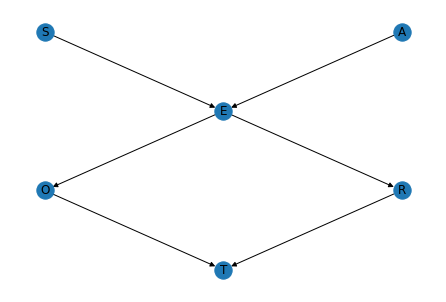

In [3]:
# Specify Graph
model = BayesianModel([
    ('A', 'E'), 
    ('S', 'E'),
    ("E", "O"),
    ("E", "R"),
    ("O", "T"),
    ("R", "T")
])

# Plot
pos = {"S":(2,5), "A":(4,5), "E":(3,4), "O":(2,3),"R":(4,3),"T":(3,2)}
nx.draw(nx.DiGraph(model.edges()), pos=pos, with_labels=True)


# Fitting a Model

From the description:

> Then, you will use a Bayesian inference technique to fit the parameter values of each conditional probability distribution using data

In [4]:
# havent figured out how to export to a dataframe or show full table

estimator = BayesianEstimator(model, df)

cpd ={}
for node in set(model.nodes) - set("T"):
    cpd[node] = estimator.estimate_cpd(
        node, 
        prior_type="dirichlet", 
        # prior concentration
        pseudo_counts=1)
    print(node)
    print("---"*5)
    print("\n")
    print(cpd[node])
    print("\n")


S
---------------


+------+----------+
| S(F) | 0.521912 |
+------+----------+
| S(M) | 0.478088 |
+------+----------+


A
---------------


+----------+----------+
| A(adult) | 0.387674 |
+----------+----------+
| A(old)   | 0.139165 |
+----------+----------+
| A(young) | 0.473161 |
+----------+----------+


O
---------------


+---------+---------------------+---------------------+
| E       | E(high)             | E(uni)              |
+---------+---------------------+---------------------+
| O(emp)  | 0.9794520547945206  | 0.9716981132075472  |
+---------+---------------------+---------------------+
| O(self) | 0.02054794520547945 | 0.02830188679245283 |
+---------+---------------------+---------------------+


R
---------------


+----------+---------------------+--------------------+
| E        | E(high)             | E(uni)             |
+----------+---------------------+--------------------+
| R(big)   | 0.7568493150684932  | 0.9339622641509434 |
+----------+------------------

# Question 4:

A categorical variable as three outcomes with probabilities p1, p2, and p3. You place a Dirichlet prior on these probabilities with concentration parameters 1, 1, and 1. In data with 20 observations you observe 10 instances of class 1, 2 instances of class 2, and 8 instances of class 3. What are the concentration parameters of the posterior.

__Does updating priors with observed counts help converge to true values?__

In [5]:
priors = np.ones(3)
nsim = 1000

In [6]:
obs = np.array([10,2,8])

# update priors with observed counts
p = stats.dirichlet(priors + obs).rvs(nsim)

# couldnt figure out vecotrized approach
posterior = np.concatenate(
    [stats.multinomial(20, p[i]).rvs() for i in range(len(p))]
)

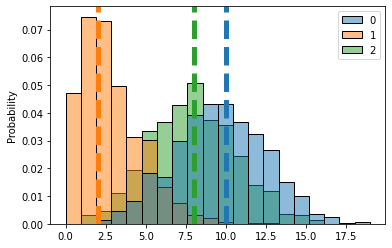

In [9]:
sns.histplot( posterior, stat="probability" )

[
    plt.axvline(obs[i], color=f"C{i}", ls="--", lw=5) 
    for i in range(len(obs))
]

It looks like concentration priors, 
$$
\alpha=\left[ 1,1,1 \right]
$$ 

simply get updated with the observed counts, 

$$
y=\left[ 10,2,8 \right]
$$

to become 

$$\alpha_{post} = \alpha + y =\left[ 1+10,1+2,1+8 \right]
$$ 